### Loading docs

In [9]:
import pandas as pd
import numpy as np
from scipy.linalg import svd
from tqdm import tqdm
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.pipeline import Pipeline
### NLTK Preprocessing
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
from nltk.corpus import stopwords
StopWords = set(stopwords.words('english'))

from sys import version_info
import argparse
import json
import matplotlib.pyplot as plt

queries_json = json.load(open(main_path + "cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_json], [item["query"] for item in queries_json]

# Read documents
docs_json = json.load(open(main_path + "cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_json], [item["body"] for item in docs_json]

### to resolve num1 discrepancy:
query_ids = list(np.array(query_ids)-1)
doc_ids = list(np.array(doc_ids)-1) 

### Building Indexes

In [10]:
vectorizer = TfidfVectorizer(stop_words=StopWords, ngram_range=(1,1))
X = vectorizer.fit_transform(docs) 
Y = vectorizer.transform(queries)   

norm_qt = Y.toarray().T
norm_doct = X.toarray().T

proc_queries = [vectorizer.build_analyzer()(query) for query in queries]                                                 
# print(proc_queries[0])

proc_docs = [vectorizer.build_analyzer()(doc) for doc in docs]                                                 
# print(proc_docs[0])

# print(norm_qt.shape)
# print(norm_doct.shape)

### Ranking

In [11]:
# Applying SVD
from scipy.sparse.linalg import svds
def svd(matrix, K):
    """ performing svd """
    U, s, VT = svds(matrix, K)           #faster sparse matrix acceleration for bigram matrices
    s = np.diag(s)
    # T_k = U[:,:K]                # (t,k) dimensions
    # S_k = np.diag(s[:K])        # (k.k) dimensions
    # DT_k = VT[:K, :]            # (k,d) dimensions
    # TF_IDF_matrix_reduced = np.dot(T_k, np.dot(S_k, DT_k))  #(t,d) dimen

    # Getting document and term representation
    # terms_rep = T_k @ S_k               # T X K matrix 
    # docs_rep = (S_k @ DT_k).T           # D x K matrix 

    # print(s)
    # plt.bar(range(20), s[:20])
    return U,s,VT


def query_transform(norm_qt, T_k, S_k):
    """ transforming query into underlying k concept space """
    DQ = norm_qt.T @ T_k @ np.linalg.inv(S_k)     # DQ X K where DQ is the number of queries
    return DQ


def ranking(DQ, DT_k, S_k, k):
    """ rank relevant docs with new representation """
    scaled_docs = DT_k.T @ S_k
    scaled_queries = DQ @ S_k
    cosine_sim_matrix = scaled_queries @ scaled_docs.T
    ind = np.argsort(cosine_sim_matrix, axis=1)
    
    best_match = np.flip(ind[:, -k:], axis=1)
    ind_list = best_match.tolist()

    return ind_list

def lsa(norm_doct, norm_qt, ck, k):    
    T_k, S_k, DT_k = svd(norm_doct, ck)
    # print(T_k.shape)
    # print(S_k.shape)
    # print(DT_k.shape)

    DQ = query_transform(norm_qt, T_k, S_k)
    rank_list = ranking(DQ, DT_k, S_k, k)
    # print(rank[:5])
    return rank_list


### Eval

In [12]:
qrels = json.load(open(main_path + "cran_qrels.json", 'r'))[:]

from big_true_IDs import big_true_IDs
big_true_IDs_ob = big_true_IDs()
big_true_IDs = big_true_IDs_ob.big_true_IDs(qrels)


### Plotting

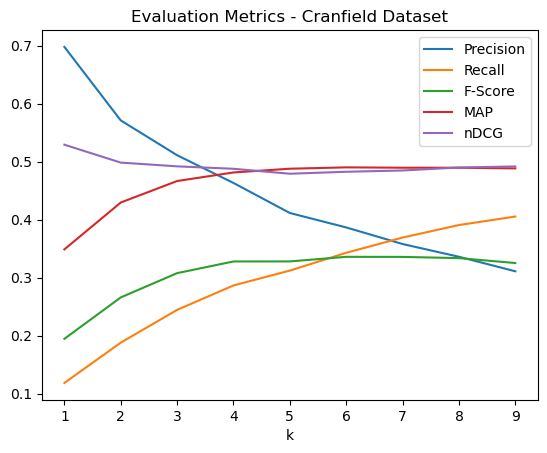

In [13]:
query_ids = list(range(225))
rank_list = lsa(norm_doct, norm_qt, 700, 10)

from plotting import plotting
plot_ob = plotting()
plot_ob.plot_measures(rank_list, query_ids, big_true_IDs, qrels, 10)

### LSA plots

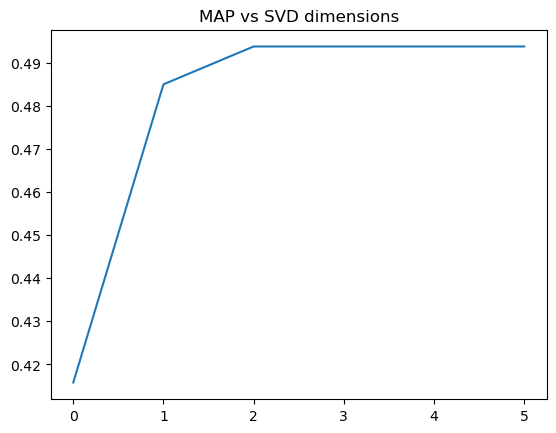

In [6]:
""" Checking MAP vs SVD dimensions plot - precision increases with increasing dimensions """
MAPs, MAPS_ck = [], []
query_ids = list(range(225))
from evaluation import Evaluation

def plot_map_vs_ck(norm_doct, norm_qt, query_ids, big_true_IDs, qrels, maxk, ck_list):
    eval = Evaluation()
    for ck in ck_list:
        rank_list = lsa(norm_doct, norm_qt, ck, 10)

        for k in range(1, maxk):
            MAP = eval.meanAveragePrecision(rank_list, query_ids, big_true_IDs, k)
            MAPs.append(MAP)            
        MAP_for_ck = np.max(MAPs)
        MAPS_ck.append(MAP_for_ck)
    
    plt.plot(range(len(ck_list)), MAPS_ck, label="MAP")
    plt.title("MAP vs SVD dimensions")
    
plot_map_vs_ck(norm_doct, norm_qt, query_ids, big_true_IDs, qrels, 10, list(range(100, 1300, 200)))

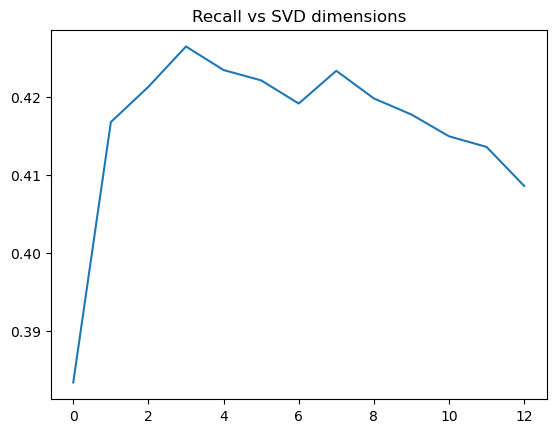

In [7]:
""" Checking Recall vs SVD dimensions plot - recall spikes, then decreases with increasing dimensions"""
Recs, Recs_ck = [], []
query_ids = list(range(225))

def plot_recall_vs_ck(norm_doct, norm_qt, query_ids, big_true_IDs, qrels, maxk, ck_list):
    eval = Evaluation()
    for ck in ck_list:
        rank_list = lsa(norm_doct, norm_qt, ck, 10)

        # for k in range(1, maxk):
        #     rec = eval.meanRecall(rank_list, query_ids, big_true_IDs, k)
        #     Recs.append(rec)      
        rec = eval.meanRecall(rank_list, query_ids, big_true_IDs, 10)
        Recs_ck.append(rec)
    
    plt.plot(range(len(ck_list)), Recs_ck, label="Recall")
    plt.title("Recall vs SVD dimensions")
    
plot_recall_vs_ck(norm_doct, norm_qt, query_ids, big_true_IDs, qrels, 10, list(range(100, 1400, 100)))

### Underperforming queries

In [14]:
from check_matches import Check_matches
check_matches = Check_matches()

rank_list = lsa(norm_doct, norm_qt, 700, 10)
bqi = check_matches.check_queries(rank_list, query_ids, big_true_IDs, qrels, 10)
print("------------------------------------------------")
print("Number of queries with 0 precision - ", len(bqi))
print("Query IDs - ", bqi)
print("------------------------------------------------")
query_index = check_matches.create_query_index(proc_queries)
doc_index = check_matches.create_doc_index(proc_docs)
check_matches.display_query_match(bqi, query_index, rank_list, doc_index)

------------------------------------------------
Number of queries with 0 precision -  15
Query IDs -  [21, 27, 34, 43, 58, 62, 73, 84, 86, 108, 109, 116, 166, 204, 215]
------------------------------------------------
for query_num =  21

query :  ['anyone', 'else', 'discover', 'turbulent', 'skin', 'friction', 'sensitive', 'nature', 'variation', 'viscosity', 'temperature']

------------------------------------------------------------------------------------
rank 1 : doc183

['scale', 'models', 'thermo', 'aeroelastic', 'research', 'investigation', 'made', 'parameters', 'satisfied', 'thermo', 'aeroelastic', 'similarity', 'concluded', 'complete', 'similarity', 'obtains', 'aircraft', 'model', 'identical', 'respects', 'including', 'size', 'limiting', 'consideration', 'conduction', 'effects', 'assuming', 'major', 'load', 'carrying', 'parts', 'structure', 'regions', 'flow', 'either', 'entirely', 'laminar', 'entirely', 'turbulent', 'assuming', 'specific', 'relationship', 'reynolds', 'number',